# Importing Histomicstk, skimage utilities

In [1]:
import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

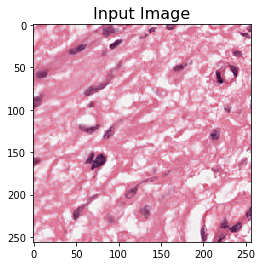

In [2]:
# Inputting image
input_image_file = ('/home/raj/github/glioma_histo_img_classifier_lob/images/TCGA-02-0001-01Z-00-DX2_20x_15424_10336_256x256.png')

im_input = skimage.io.imread(input_image_file)[:, :, :3]

plt.imshow(im_input)
_ = plt.title('Input Image', fontsize=16)

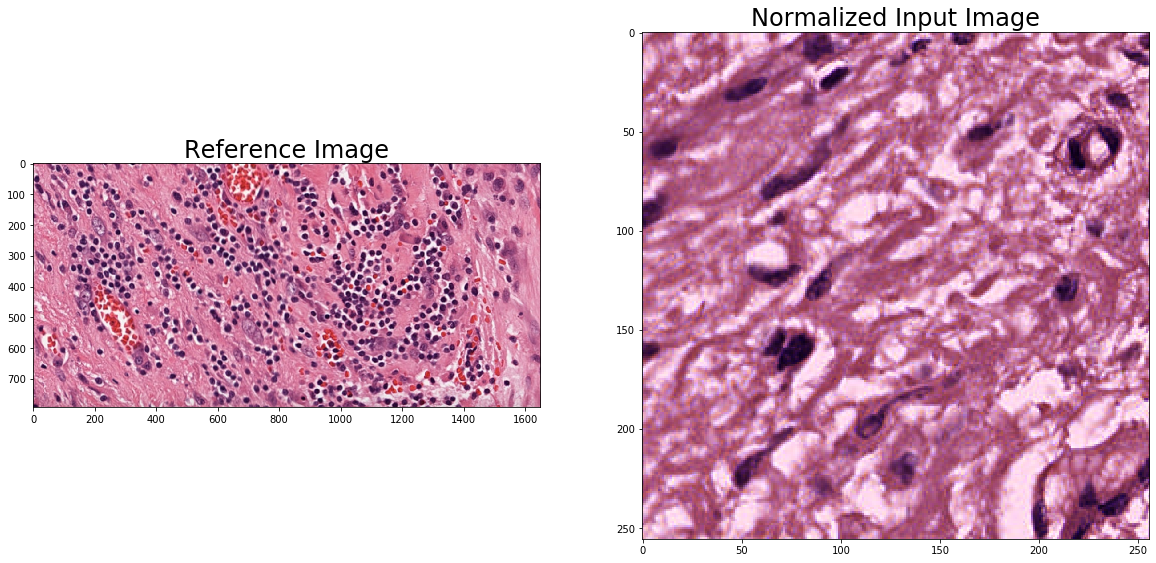

In [3]:
# Load reference image for normalization
ref_image_file = ('https://data.kitware.com/api/v1/file/'
                  '57718cc28d777f1ecd8a883c/download')  # L1.png

im_reference = skimage.io.imread(ref_image_file)[:, :, :3]

# get mean and stddev of reference image in lab space
mean_ref, std_ref = htk.preprocessing.color_conversion.lab_mean_std(im_reference)

# perform reinhard color normalization
im_nmzd = htk.preprocessing.color_normalization.reinhard(im_input, mean_ref, std_ref)

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(im_reference)
_ = plt.title('Reference Image', fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow(im_nmzd)
_ = plt.title('Normalized Input Image', fontsize=titlesize)


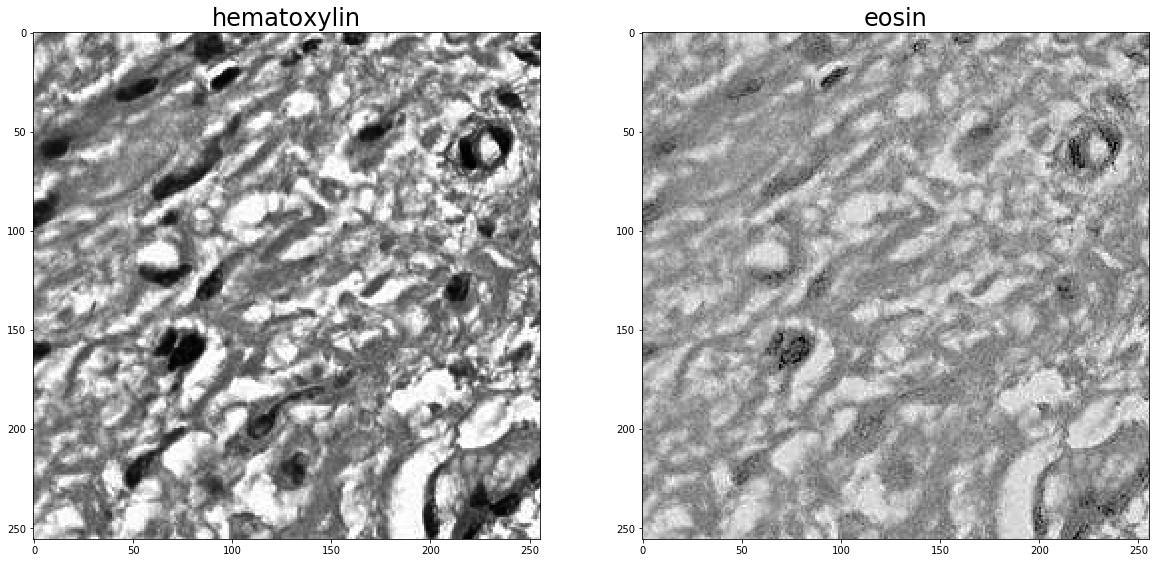

In [4]:
# create stain to color map
stainColorMap = {
    'hematoxylin': [0.65, 0.70, 0.29],
    'eosin':       [0.07, 0.99, 0.11],
    'dab':         [0.27, 0.57, 0.78],
    'null':        [0.0, 0.0, 0.0]
}

# specify stains of input image
stain_1 = 'hematoxylin'   # nuclei stain
stain_2 = 'eosin'         # cytoplasm stain
stain_3 = 'null'          # set to null of input contains only two stains

# create stain matrix
W = np.array([stainColorMap[stain_1],
              stainColorMap[stain_2],
              stainColorMap[stain_3]]).T

# perform standard color deconvolution
im_stains = htk.preprocessing.color_deconvolution.color_deconvolution(im_nmzd, W).Stains

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(im_stains[:, :, 0])
plt.title(stain_1, fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow(im_stains[:, :, 1])
_ = plt.title(stain_2, fontsize=titlesize)

Number of nuclei =  14


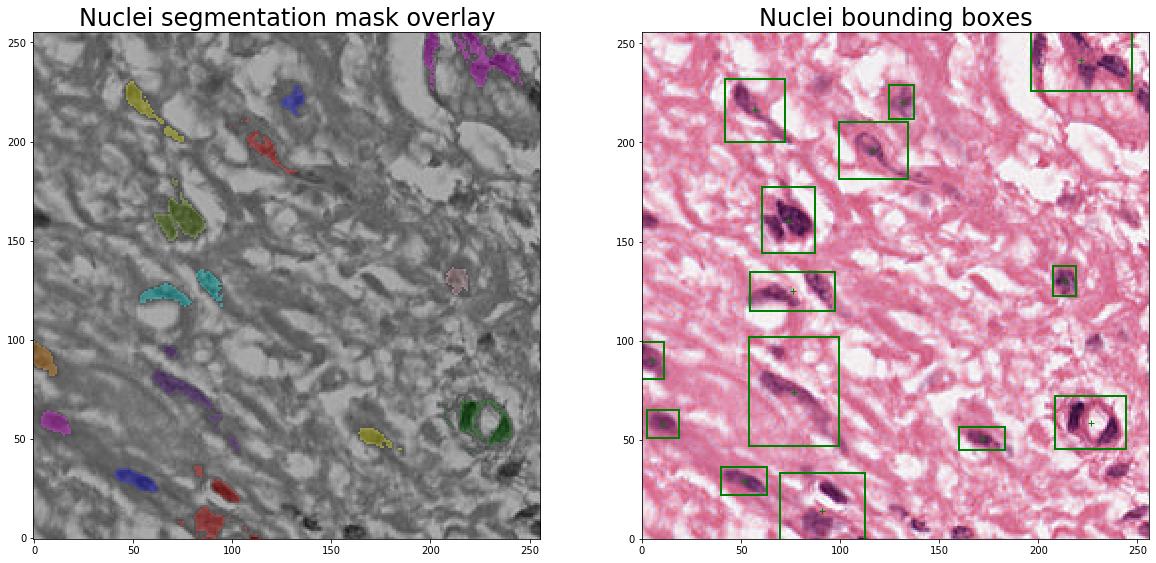

In [5]:
# get nuclei/hematoxylin channel
im_nuclei_stain = im_stains[:, :, 0]

# segment foreground
foreground_threshold = 60

im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
    im_nuclei_stain < foreground_threshold)

# run adaptive multi-scale LoG filter
min_radius = 10
max_radius = 15

im_log_max, im_sigma_max = htk.filters.shape.cdog(
    im_nuclei_stain, im_fgnd_mask,
    sigma_min=min_radius * np.sqrt(2),
    sigma_max=max_radius * np.sqrt(2)
)

# detect and segment nuclei using local maximum clustering
local_max_search_radius = 10

im_nuclei_seg_mask, seeds, maxima = htk.segmentation.nuclear.max_clustering(
    im_log_max, im_fgnd_mask, local_max_search_radius)

# filter out small objects
min_nucleus_area = 80

im_nuclei_seg_mask = htk.segmentation.label.area_open(
    im_nuclei_seg_mask, min_nucleus_area).astype(np.int)

# compute nuclei properties
objProps = skimage.measure.regionprops(im_nuclei_seg_mask)

print('Number of nuclei = ', len(objProps))

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(skimage.color.label2rgb(im_nuclei_seg_mask, im_input, bg_label=0), origin='lower')
plt.title('Nuclei segmentation mask overlay', fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow( im_input )
plt.xlim([0, im_input.shape[1]])
plt.ylim([0, im_input.shape[0]])
plt.title('Nuclei bounding boxes', fontsize=titlesize)

for i in range(len(objProps)):

    c = [objProps[i].centroid[1], objProps[i].centroid[0], 0]
    width = objProps[i].bbox[3] - objProps[i].bbox[1] + 1
    height = objProps[i].bbox[2] - objProps[i].bbox[0] + 1

    cur_bbox = {
        "type":        "rectangle",
        "center":      c,
        "width":       width,
        "height":      height,
    }

    plt.plot(c[0], c[1], 'g+')
    mrect = mpatches.Rectangle([c[0] - 0.5 * width, c[1] - 0.5 * height] ,
                               width, height, fill=False, ec='g', linewidth=2)
    plt.gca().add_patch(mrect)

In [6]:
import numpy as np
import pandas as pd
from skimage.measure import regionprops
from skimage.segmentation import find_boundaries


def compute_fsd_features(im_label, K=128, Fs=6, Delta=8, rprops=None):
    """
    Calculates `Fourier shape descriptors` for each objects.
    Parameters
    ----------
    im_label : array_like
        A labeled mask image wherein intensity of a pixel is the ID of the
        object it belongs to. Non-zero values are considered to be foreground
        objects.
    K : int, optional
        Number of points for boundary resampling to calculate fourier
        descriptors. Default value = 128.
    Fs : int, optional
        Number of frequency bins for calculating FSDs. Default value = 6.
    Delta : int, optional
        Used to dilate nuclei and define cytoplasm region. Default value = 8.
    rprops : output of skimage.measure.regionprops, optional
        rprops = skimage.measure.regionprops( im_label ). If rprops is not
        passed then it will be computed inside which will increase the
        computation time.
    Returns
    -------
    fdata: Pandas data frame containing the FSD features for each
           object/label.
    References
    ----------
    .. [#] D. Zhang et al. "A comparative study on shape retrieval using
       Fourier descriptors with different shape signatures," In Proc.
       ICIMADE01, 2001.
    """
    # List of feature names
    feature_list = []
    for i in range(0, Fs):
        feature_list = np.append(feature_list, 'Shape.FSD' + str(i+1))

    # get Label size x
    sizex = im_label.shape[0]
    sizey = im_label.shape[1]

    # get the number of objects in Label
    if rprops is None:
        rprops = regionprops(im_label)

    # create pandas data frame containing the features for each object
    numFeatures = len(feature_list)
    numLabels = len(rprops)
    fdata = pd.DataFrame(np.zeros((numLabels, numFeatures)),
                         columns=feature_list)

    # fourier descriptors, spaced evenly over the interval 1:K/2
    Interval = np.round(
        np.power(
            2, np.linspace(0, np.log2(K)-1, Fs+1, endpoint=True)
        )
    ).astype(np.uint8)

    for i in range(numLabels):
        # get bounds of dilated nucleus
        min_row, max_row, min_col, max_col = \
            _GetBounds(rprops[i].bbox, Delta, sizex, sizey)
        # grab label mask
        lmask = (
            im_label[min_row:max_row, min_col:max_col] == rprops[i].label
        ).astype(np.bool)
        # find boundaries
        Bounds = np.argwhere(
            find_boundaries(lmask, mode="inner").astype(np.uint8) == 1
        )
        # check length of boundaries
        if len(Bounds) < 2:
            fdata.at[i, :] = 0
        else:
            # compute fourier descriptors
            fdata.at[i, :] = _FSDs(Bounds[:, 0], Bounds[:, 1], K, Interval)

    return fdata


def _InterpolateArcLength(X, Y, K):
    """
    Resamples boundary points [X, Y] at L total equal arc-length locations.
    Parameters
    ----------
    X : array_like
        x points of boundaries
    Y : array_like
        y points of boundaries
    K : int
        Number of points for boundary resampling to calculate fourier
        descriptors. Default value = 128.
    Returns
    -------
    iX : array_like
        L-length vector of horizontal interpolated coordinates with equal
        arc-length spacing.
    iY : array_like
        L-length vector of vertical interpolated coordinates with equal
        arc-length spacing.
    """

    # generate spaced points 0, 1/k, 1
    interval = np.linspace(0, 1, K+1)
    # get segment lengths
    slens = np.sqrt(np.diff(X)**2 + np.diff(Y)**2)
    # normalize to unit length
    slens = np.true_divide(slens, slens.sum())
    # calculate cumulative length along boundary
    cumulative = np.zeros(len(slens)+1)
    cumulative[1:] = np.cumsum(slens)
    # place points in 'Interval' along boundary
    locations = np.digitize(interval, cumulative)
    # clip to ends
    locations[locations > len(slens)] = len(slens)
    # linear interpolation
    Lie = (interval - cumulative[locations-1])/slens[locations-1]
    iX = X[locations-1] + (X[locations]-X[locations-1])*Lie
    iY = Y[locations-1] + (Y[locations]-Y[locations-1])*Lie

    return iX, iY


def _FSDs(X, Y, K, Intervals):
    """
    Calculated FSDs from boundary points X,Y. Boundaries are resampled to have
    K equally spaced points (arclength) around the shape. The curvature is
    calculated using the cumulative angular function, measuring the
    displacement of the tangent angle from the starting point of the boundary.
    The K-length fft of the cumulative angular function is calculated, and
    then the elements of 'F' are summed as the spectral energy over
    'Intervals'.
    Parameters
    ----------
    X : array_like
        x points of boundaries
    Y : array_like
        y points of boundaries
    K : int
        Number of points for boundary resampling to calculate fourier
        descriptors. Default value = 128.
    Intervals : array_like
        Intervals spaced evenly over 1:K/2.
    Returns
    -------
    F : array_like
        length(Intervals) vector containing spectral energy of
        cumulative angular function, summed over defined 'Intervals'.
    """

    # check input 'Intervals'
    if Intervals[0] != 1.:
        Intervals = np.hstack((1., Intervals))
    if Intervals[-1] != (K / 2):
        Intervals = np.hstack((Intervals, float(K)))
    # get length of intervals
    L = len(Intervals)
    # initialize F
    F = np.zeros((L-1, )).astype(float)
    # interpolate boundaries
    iX, iY = _InterpolateArcLength(X, Y, K)
    # check if iXY.iX is not empty
    if iX.size:
        # calculate curvature
        Curvature = np.arctan2(
            (iY[1:] - iY[:-1]),
            (iX[1:] - iX[:-1])
        )
        # make curvature cumulative
        Curvature = Curvature - Curvature[0]
        # calculate FFT
        fX = np.fft.fft(Curvature).T
        # spectral energy
        fX = fX * fX.conj()
        fX = fX / fX.sum()
        # calculate 'F' values
        for i in range(L-1):
            F[i] = np.round(
                fX[Intervals[i]-1:Intervals[i+1]].sum(), L
            ).real.astype(float)

    return F


def _GetBounds(bbox, delta, M, N):
    """
    Returns bounds of object in global label image.
    Parameters
    ----------
    bbox : tuple
        Bounding box (min_row, min_col, max_row, max_col).
    delta : int
        Used to dilate nuclei and define cytoplasm region.
        Default value = 8.
    M : int
        X size of label image.
    N : int
        Y size of label image.
    Returns
    -------
    min_row : int
        Minum row of the region bounds.
    max_row : int
        Maximum row of the region bounds.
    min_col : int
        Minum column of the region bounds.
    max_col : int
        Maximum column of the region bounds.
    """

    min_row, min_col, max_row, max_col = bbox

    min_row_out = max(0, (min_row - delta))
    max_row_out = min(M-1, (max_row + delta))
    min_col_out = max(0, (min_col - delta))
    max_col_out = min(N-1, (max_col + delta))

    return min_row_out, max_row_out, min_col_out, max_col_out

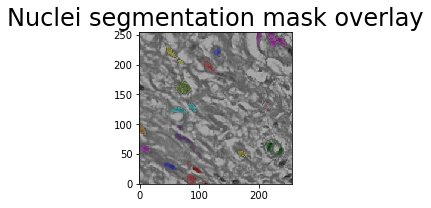

In [7]:
nuclei_plt=plt.subplot(1, 2, 1)
plt.imshow(skimage.color.label2rgb(im_nuclei_seg_mask, im_input, bg_label=0), origin='lower')
plt.title('Nuclei segmentation mask overlay', fontsize=titlesize)

nuclei_plt

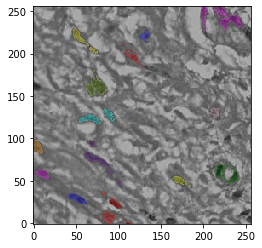

In [8]:
plt.imshow(skimage.color.label2rgb(im_nuclei_seg_mask, im_input, bg_label=0), origin='lower')

In [9]:
im_nuclei_seg_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [10]:
compute_fsd_features(im_nuclei_seg_mask)

,Shape.FSD1,Shape.FSD2,Shape.FSD3,Shape.FSD4,Shape.FSD5,Shape.FSD6
0,0.526107,0.001604,0.005399,0.065780,0.096151,0.080612
1,0.302942,0.000851,0.000773,0.240702,0.070445,0.035032
2,0.496805,0.001419,0.007093,0.202371,0.026881,0.022923
3,0.112602,0.001476,0.004747,0.328647,0.083866,0.044148
4,0.394140,0.002379,0.002063,0.018987,0.239897,0.047794
5,0.372656,0.001187,0.002493,0.013203,0.176832,0.126311
6,0.579096,0.006989,0.127560,0.027602,0.040389,0.018388
7,0.501872,0.001074,0.006228,0.168109,0.048011,0.052653
8,0.351908,0.001335,0.002476,0.235498,0.062662,0.045739
9,0.275622,0.001083,0.002178,0.057204,0.275698,0.074957
